In [1]:
#################################################################
#################################################################
# Rozwiązanie zadania laboratoryjnego przy pomocy pakietu AMORE #
#################################################################
#################################################################

In [2]:
# Załadowanie bibliotek
library(tidyverse)
library(AMORE)
library(pROC)
library(caret)

Warning message:
"package 'tidyverse' was built under R version 4.4.2"
Warning message:
"package 'readr' was built under R version 4.4.2"
Warning message:
"package 'dplyr' was built under R version 4.4.2"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'pROC' was built under R version 4.4.2"
Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Warning message:
"package 'caret' was built under R vers

In [3]:
########################
# Przygotowanie danych #
########################

# Usuniecie obiektow dla czystego startu modelu
rm(list = ls())

# Wczytanie danych
wesbrook <- read_csv('http://jolej.linuxpl.info/Wesbrook.csv', col_types = "ifncfffffffffcffffinnnnnnnfnnnn")

# Sprawdzenie ile jest brakujacych wartosci
print(sort(colSums(is.na(wesbrook)), decreasing = TRUE))
rows_with_na <- wesbrook[rowSums(is.na(wesbrook)) > 0, ]
print(rows_with_na)
print(nrow(rows_with_na))

# Usuniecie kolumny INDUPDT - zbedna dana
wesbrook <- wesbrook %>% select(-INDUPDT)

# Usuniecie kolumny EA - zbedna dana
wesbrook <- wesbrook %>% select(-EA)

# Usuniecie kolumny BIGBLOCK - nikt nie wzial udzialu w tym programie
wesbrook <- wesbrook %>% select(-BIGBLOCK)

# Sprawdzenie wartosci dla kolumny MARITAL wraz z brakujacymi wartosciami
print(table(wesbrook$MARITAL, useNA = "ifany"))

# Dla braku statusu malzenskiego przypisac wartosc "S" ("single")
wesbrook$MARITAL[is.na(wesbrook$MARITAL)] <- "S"

# Ustawienie brakujacych wartosci sredniego dochodu AVE_INC jako srednia ze wszystkich wartosci
wesbrook$AVE_INC[is.na(wesbrook$AVE_INC)] <- mean(wesbrook$AVE_INC, na.rm = TRUE)

# Ustawienie brakujacych wartosci odchylenia standardowego SD_INC jako srednia ze wszystkich wartosci
wesbrook$SD_INC[is.na(wesbrook$SD_INC)] <- mean(wesbrook$SD_INC, na.rm = TRUE)

# Inputacja innych brakujących danych
wesbrook <- wesbrook %>%
  mutate(across(where(is.numeric), ~ ifelse(is.na(.), mean(., na.rm = TRUE), .))) %>%
  mutate(across(where(is.factor), ~ ifelse(is.na(.), levels(.)[which.max(table(.))], .)))

# Przekształcenie zmiennej WESBROOK na binarną (0 = "F", 1 = "Y")
wesbrook$WESBROOK <- ifelse(wesbrook$WESBROOK == 2, 1, 0)

# Usuniecie pozostalych rekordow z brakujacymi wartosciami
wesbrook <- wesbrook %>% drop_na()

# Konwersja wszystkich kolumn na numeryczne
wesbrook <- wesbrook %>%
  mutate(across(everything(), ~ as.numeric(as.factor(.))))

# Funkcja normalizujaca metoda min - max
normalize <- function(x) {
  if (min(x) == max(x)) {
    return(rep(0, length(x)))
  } else {
    return((x - min(x)) / (max(x) - min(x)))
  }
}

wesbrook <- wesbrook %>%
  mutate(across(where(is.numeric), normalize))

# Podział na zbiór treningowy i walidacyjny
set.seed(1234)
sample_index <- sample(1:nrow(wesbrook), size = 0.8 * nrow(wesbrook))
wesbrook_train <- wesbrook[sample_index, ]
wesbrook_test <- wesbrook[-sample_index, ]

# Przygotowanie macierzy wejściowych (WE) i wyjściowych (WY)
WE <- as.matrix(wesbrook_train[, -which(colnames(wesbrook_train) == "WESBROOK")])  # Wszystkie cechy oprócz WESBROOK
WY <- as.vector(as.numeric(wesbrook_train$WESBROOK))  # Wartości docelowe

VAL_WE <- as.matrix(wesbrook_test[, -which(colnames(wesbrook_test) == "WESBROOK")])  # Walidacyjne cechy
VAL_WY <- as.vector(as.numeric(wesbrook_test$WESBROOK))  # Walidacyjne wartości docelowe

  MAJOR1  MARITAL  GRADYR1 FACULTY1    DEPT1 FRSTYEAR  AVE_INC   SD_INC 
    1964     1815      947      947      947      947       71       71 
CNDN_PCT MOV_DWEL  HH_1PER  HH_2PER  HH_3PER HH_45PER DWEL_VAL  ENG_PCT 
      29       28       28       28       28       28       28       28 
 OWN_PCT     PROV       EA  INDUPDT       ID WESBROOK TOTLGIVE   PARENT 
      28       17       13       12        0        0        0        0 
   CHILD   SPOUSE      SEX FACSTAFF  ATHLTCS BIGBLOCK OTHERACT 
       0        0        0        0        0        0        0 
# A tibble: 2,488 × 31
      ID WESBROOK TOTLGIVE INDUPDT    GRADYR1 FACULTY1 DEPT1 MAJOR1 PARENT CHILD
   <int> <fct>       <dbl> <chr>      <fct>   <fct>    <fct> <fct>  <fct>  <fct>
 1    88 Y           24728 10/02/1995 1960    CO       CO    NA     Y      Y    
 2   152 Y           23500 07/21/1997 1988    PO       PO    NA     N      N    
 3   158 Y            7600 12/21/1996 NA      NA       NA    NA     N      N    
 4   1

In [4]:
########################################
# Tworzenie i uczenie sieci neuronowej #
########################################

# Definicja sieci neuronowej
net <- newff(
  n.neurons = c(ncol(WE), 20, 1),  # Struktura sieci
  learning.rate.global = 0.001,  # Współczynnik szybkości uczenia
  momentum.global = 0.5,  # Współczynnik momentum
  error.criterium = "TAO", Stao = NA,  # Sposób liczenia błędu
  hidden.layer = "tansig",  # Funkcja aktywacji dla warstw ukrytych
  output.layer = "purelin",  # Funkcja aktywacji warstwy wyjściowej
  method = "ADAPTgdwm"  # Algorytm uczenia sieci
)

# Trenowanie sieci
result <- AMORE::train(
  net, WE, WY, VAL_WE, VAL_WY,  # Dane uczenia
  error.criterium = "LMS",  # Kryterium błędu "LMS" - "Least Mean Squares"
  show.step = 40,  # Co ile epok wyświetlać postęp
  n.shows = 20  # Maksymalna liczba raportów do wyświetlenia
)

index.show: 1 LMS 	TRAIN: 0.0838224218710335 	VAL: 0.0938372988597524 	 BEST NET
index.show: 2 LMS 	TRAIN: 0.0725911813050195 	VAL: 0.079984093831556 	 BEST NET
index.show: 3 LMS 	TRAIN: 0.0578384469979592 	VAL: 0.0634262788375981 	 BEST NET
index.show: 4 LMS 	TRAIN: 0.0524242144211084 	VAL: 0.0579790807202342 	 BEST NET
index.show: 5 LMS 	TRAIN: 0.051545642530933 	VAL: 0.057122777260155 	 BEST NET
index.show: 6 LMS 	TRAIN: 0.0511291790389875 	VAL: 0.0566738787006127 	 BEST NET
index.show: 7 LMS 	TRAIN: 0.0508289543066572 	VAL: 0.0563424552119859 	 BEST NET
index.show: 8 LMS 	TRAIN: 0.050590251713451 	VAL: 0.0560786973521198 	 BEST NET
index.show: 9 LMS 	TRAIN: 0.0503847605342977 	VAL: 0.0558539543425556 	 BEST NET
index.show: 10 LMS 	TRAIN: 0.050195455000932 	VAL: 0.0556508511639217 	 BEST NET
index.show: 11 LMS 	TRAIN: 0.0500111058523898 	VAL: 0.055458084965391 	 BEST NET
index.show: 12 LMS 	TRAIN: 0.0498235978007074 	VAL: 0.0552677214649274 	 BEST NET
index.show: 13 LMS 	TRAIN: 0.04

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 285  16
         1   9 244
                                          
               Accuracy : 0.9549          
                 95% CI : (0.9341, 0.9706)
    No Information Rate : 0.5307          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9093          
                                          
 Mcnemar's Test P-Value : 0.2301          
                                          
            Sensitivity : 0.9694          
            Specificity : 0.9385          
         Pos Pred Value : 0.9468          
         Neg Pred Value : 0.9644          
             Prevalence : 0.5307          
         Detection Rate : 0.5144          
   Detection Prevalence : 0.5433          
      Balanced Accuracy : 0.9539          
                                          
       'Positive' Class : 0               
                              

Setting levels: control = 0, case = 1

Warning message in roc.default(factor(VAL_WY), predictions):
"Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector."
Setting direction: controls < cases



[1] "AUC: 0.981658817373103"


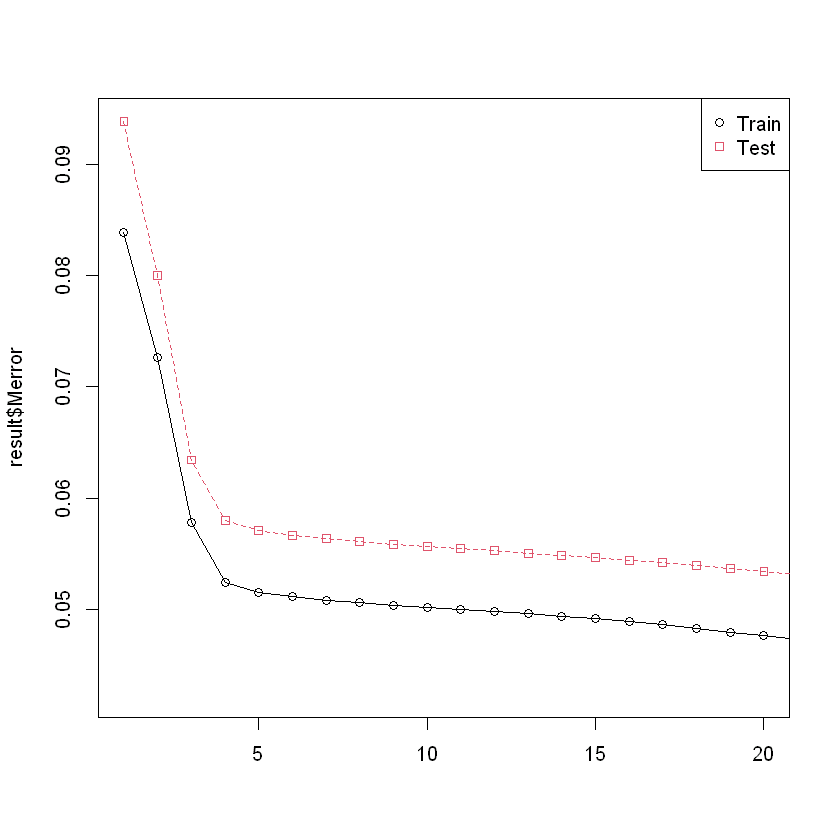

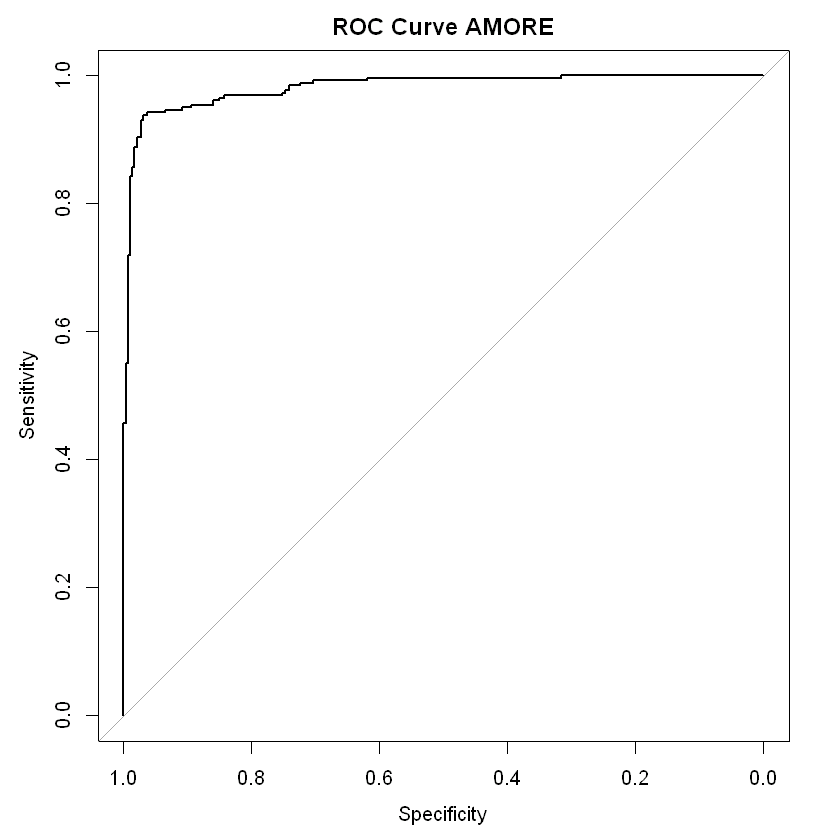

In [5]:
######################################
# Analiza nauczonej sieci neuronowej #
######################################

# Krzywa uczenia
matplot(result$Merror, pch=21:23, type="o", xlim=c(1, 20), ylim=range(result$Merror), col=1:2)
legend("topright", legend=c("Train", "Test"), pch=21:22, col=1:2)

# Predykcja dla danych walidacyjnych
predictions <- sim(result$net, VAL_WE)
predictions_binary <- as.numeric(predictions > 0.5)  # Konwersja na wartości binarne

# Macierz konfusji, dokładność
confusionMatrix(factor(predictions_binary), factor(VAL_WY))

# Obliczanie krzywej ROC
roc_curve <- roc(factor(VAL_WY), predictions)

# Wyznaczenie AUC
auc_value <- auc(roc_curve)
auc_value

# Rysowanie krzywej ROC
plot(roc_curve, main = "ROC Curve AMORE")

In [ ]:
################################################################
################################################################
# Rozwiązanie zadania laboratoryjnego przy pomocy pakietu nnet #
################################################################
################################################################

In [ ]:
# Załadowanie bibliotek
library(tidyverse)
library(nnet)
library(pROC)
library(caret)

In [ ]:
########################
# Przygotowanie danych #
########################

# Usuniecie obiektow dla czystego startu modelu
rm(list = ls())

# Wczytanie danych
wesbrook <- read_csv('http://jolej.linuxpl.info/Wesbrook.csv', col_types = "ifncfffffffffcffffinnnnnnnfnnnn")

# Sprawdzenie ile jest brakujacych wartosci
print(sort(colSums(is.na(wesbrook)), decreasing = TRUE))
rows_with_na <- wesbrook[rowSums(is.na(wesbrook)) > 0, ]
print(rows_with_na)
print(nrow(rows_with_na))

# Usuniecie kolumny INDUPDT - zbedna dana
wesbrook <- wesbrook %>% select(-INDUPDT)

# Usuniecie kolumny EA - zbedna dana
wesbrook <- wesbrook %>% select(-EA)

# Usuniecie kolumny BIGBLOCK - nikt nie wzial udzialu w tym programie
wesbrook <- wesbrook %>% select(-BIGBLOCK)

# Sprawdzenie wartosci dla kolumny MARITAL wraz z brakujacymi wartosciami
print(table(wesbrook$MARITAL, useNA = "ifany"))

# Dla braku statusu malzenskiego przypisac wartosc "S" ("single")
wesbrook$MARITAL[is.na(wesbrook$MARITAL)] <- "S"

# Ustawienie brakujacych wartosci sredniego dochodu AVE_INC jako srednia ze wszystkich wartosci
wesbrook$AVE_INC[is.na(wesbrook$AVE_INC)] <- mean(wesbrook$AVE_INC, na.rm = TRUE)

# Ustawienie brakujacych wartosci odchylenia standardowego SD_INC jako srednia ze wszystkich wartosci
wesbrook$SD_INC[is.na(wesbrook$SD_INC)] <- mean(wesbrook$SD_INC, na.rm = TRUE)

# Inputacja innych brakujących danych
wesbrook <- wesbrook %>%
  mutate(across(where(is.numeric), ~ ifelse(is.na(.), mean(., na.rm = TRUE), .))) %>%
  mutate(across(where(is.factor), ~ ifelse(is.na(.), levels(.)[which.max(table(.))], .)))

# Przekształcenie zmiennej WESBROOK na binarną (0 = "F", 1 = "Y")
wesbrook$WESBROOK <- ifelse(wesbrook$WESBROOK == 2, 1, 0)

# Usuniecie pozostalych rekordow z brakujacymi wartosciami
wesbrook <- wesbrook %>% drop_na()

# Konwersja wszystkich kolumn na numeryczne
wesbrook <- wesbrook %>%
  mutate(across(everything(), ~ as.numeric(as.factor(.))))

# Funkcja normalizujaca metoda min - max
normalize <- function(x) {
  if (min(x) == max(x)) {
    return(rep(0, length(x)))
  } else {
    return((x - min(x)) / (max(x) - min(x)))
  }
}

wesbrook <- wesbrook %>%
  mutate(across(where(is.numeric), normalize))

# Podział na zbiór treningowy i walidacyjny
set.seed(1234)
sample_index <- sample(1:nrow(wesbrook), size = 0.8 * nrow(wesbrook))
wesbrook_train <- wesbrook[sample_index, ]
wesbrook_test <- wesbrook[-sample_index, ]

# Przygotowanie macierzy wejściowych (WE) i wyjściowych (WY)
WE <- as.matrix(wesbrook_train[, -which(colnames(wesbrook_train) == "WESBROOK")])  # Wszystkie cechy oprócz WESBROOK
WY <- as.vector(as.numeric(wesbrook_train$WESBROOK))  # Wartości docelowe

VAL_WE <- as.matrix(wesbrook_test[, -which(colnames(wesbrook_test) == "WESBROOK")])  # Walidacyjne cechy
VAL_WY <- as.vector(as.numeric(wesbrook_test$WESBROOK))  # Walidacyjne wartości docelowe

In [ ]:
########################################
# Tworzenie i uczenie sieci neuronowej #
########################################

# Tworzenie i trenowanie modelu
model <- nnet(
  x = WE,
  y = WY,
  size = 15,  # Liczba neuronów w warstwie ukrytej
  linout = FALSE,  # Klasyfikacja binarna
  softmax = FALSE,
  maxit = 200,
  decay = 0.01
)
# Tworzenie i trenowanie modelu
model <- nnet(
  x = WE,  # Dane wejściowe
  y = WY,  # Dane wyjściowe
  size = 30,  # Liczba neuronów w warstwie ukrytej
  linout = FALSE,  # Czy używać regresji liniowej?
  softmax = FALSE,  # Czy używać funkcji softmax do normalizacji wyjść?
  maxit = 200,  # Maksymalna liczba iteracji algorytmu optymalizacyjnego
  decay = 0.01  # Współczynnik regularizacji (zapobiega przeuczeniu)
)

In [ ]:
######################################
# Analiza nauczonej sieci neuronowej #
######################################

# Predykcja dla danych walidacyjnych
predictions <- predict(model, VAL_WE, type = "raw")
predictions_binary <- as.numeric(predictions > 0.5)  # Konwersja na wartości binarne

# Macierz konfusji, dokładność
confusionMatrix(factor(predictions_binary), factor(VAL_WY))

# Obliczanie krzywej ROC
roc_curve <- roc(factor(VAL_WY), predictions)

# Wyznaczenie AUC
auc_value <- auc(roc_curve)
auc_value

# Rysowanie krzywej ROC
plot(roc_curve, main = "ROC Curve nnet")

In [ ]:
#################################################################
#################################################################
# Rozwiązanie zadania laboratoryjnego przy pomocy pakietu RSNNS #
#################################################################
#################################################################

In [ ]:
# Załadowanie bibliotek
library(tidyverse)
library(RSNNS)
library(pROC)
library(caret)

In [ ]:
########################
# Przygotowanie danych #
########################

# Usuniecie obiektow dla czystego startu modelu
rm(list = ls())

# Wczytanie danych
wesbrook <- read_csv('http://jolej.linuxpl.info/Wesbrook.csv', col_types = "ifncfffffffffcffffinnnnnnnfnnnn")

# Sprawdzenie ile jest brakujacych wartosci
print(sort(colSums(is.na(wesbrook)), decreasing = TRUE))
rows_with_na <- wesbrook[rowSums(is.na(wesbrook)) > 0, ]
print(rows_with_na)
print(nrow(rows_with_na))

# Usuniecie kolumny INDUPDT - zbedna dana
wesbrook <- wesbrook %>% select(-INDUPDT)

# Usuniecie kolumny EA - zbedna dana
wesbrook <- wesbrook %>% select(-EA)

# Usuniecie kolumny BIGBLOCK - nikt nie wzial udzialu w tym programie
wesbrook <- wesbrook %>% select(-BIGBLOCK)

# Sprawdzenie wartosci dla kolumny MARITAL wraz z brakujacymi wartosciami
print(table(wesbrook$MARITAL, useNA = "ifany"))

# Dla braku statusu malzenskiego przypisac wartosc "S" ("single")
wesbrook$MARITAL[is.na(wesbrook$MARITAL)] <- "S"

# Ustawienie brakujacych wartosci sredniego dochodu AVE_INC jako srednia ze wszystkich wartosci
wesbrook$AVE_INC[is.na(wesbrook$AVE_INC)] <- mean(wesbrook$AVE_INC, na.rm = TRUE)

# Ustawienie brakujacych wartosci odchylenia standardowego SD_INC jako srednia ze wszystkich wartosci
wesbrook$SD_INC[is.na(wesbrook$SD_INC)] <- mean(wesbrook$SD_INC, na.rm = TRUE)

# Inputacja innych brakujących danych
wesbrook <- wesbrook %>%
  mutate(across(where(is.numeric), ~ ifelse(is.na(.), mean(., na.rm = TRUE), .))) %>%
  mutate(across(where(is.factor), ~ ifelse(is.na(.), levels(.)[which.max(table(.))], .)))

# Przekształcenie zmiennej WESBROOK na binarną (0 = "F", 1 = "Y")
wesbrook$WESBROOK <- ifelse(wesbrook$WESBROOK == 2, 1, 0)

# Usuniecie pozostalych rekordow z brakujacymi wartosciami
wesbrook <- wesbrook %>% drop_na()

# Konwersja wszystkich kolumn na numeryczne
wesbrook <- wesbrook %>%
  mutate(across(everything(), ~ as.numeric(as.factor(.))))

# Funkcja normalizujaca metoda min - max
normalize <- function(x) {
  if (min(x) == max(x)) {
    return(rep(0, length(x)))
  } else {
    return((x - min(x)) / (max(x) - min(x)))
  }
}

wesbrook <- wesbrook %>%
  mutate(across(where(is.numeric), normalize))

# Podział na zbiór treningowy i walidacyjny
set.seed(1234)
sample_index <- sample(1:nrow(wesbrook), size = 0.8 * nrow(wesbrook))
wesbrook_train <- wesbrook[sample_index, ]
wesbrook_test <- wesbrook[-sample_index, ]

# Przygotowanie macierzy wejściowych (WE) i wyjściowych (WY)
WE <- as.matrix(wesbrook_train[, -which(colnames(wesbrook_train) == "WESBROOK")])  # Wszystkie cechy oprócz WESBROOK
WY <- as.vector(as.numeric(wesbrook_train$WESBROOK))  # Wartości docelowe

VAL_WE <- as.matrix(wesbrook_test[, -which(colnames(wesbrook_test) == "WESBROOK")])  # Walidacyjne cechy
VAL_WY <- as.vector(as.numeric(wesbrook_test$WESBROOK))  # Walidacyjne wartości docelowe

In [ ]:
########################################
# Tworzenie i uczenie sieci neuronowej #
########################################

# Tworzenie i trenowanie modelu
model <- mlp(
  x = WE,  # Dane wejściowe
  y = WY,  # Dane wyjściowe
  size = 30,  # Liczba neuronów w warstwie ukrytej
  maxit = 200,  # Maksymalna liczba iteracji
  initFunc = "Randomize_Weights",  # Funkcja inicjalizacji wag (tutaj losowa)
  initFuncParams = c(-0.3, 0.3),  # Zakres wartości początkowych dla wag
  learnFunc = "Std_Backpropagation",  # Funkcja uczenia
  learnFuncParams = c(0.01, 0.7),  # Parametry learning rate i momentum
  updateFunc = "Topological_Order",  # Kolejność aktualizacji wag
  hiddenActFunc = "Act_Logistic",  # Funkcja aktywacji w warstwach ukrytych
  shufflePatterns = TRUE  # Mieszanie wzorców przy uczeniu
)

In [ ]:
######################################
# Analiza nauczonej sieci neuronowej #
######################################

# Predykcja dla danych walidacyjnych
predictions <- predict(model, VAL_WE, type = "raw")
predictions_binary <- as.numeric(predictions > 0.5)  # Konwersja na wartości binarne

# Macierz konfusji, dokładność
confusionMatrix(factor(predictions_binary), factor(VAL_WY))

# Obliczanie krzywej ROC
roc_curve <- roc(factor(VAL_WY), predictions)

# Wyznaczenie AUC
auc_value <- auc(roc_curve)
auc_value

# Rysowanie krzywej ROC
plot(roc_curve, main = "ROC Curve RSNNS")

In [ ]:
#####################################################################
#####################################################################
# Rozwiązanie zadania laboratoryjnego przy pomocy pakietu neuralnet #
#####################################################################
#####################################################################

In [ ]:
# Załadowanie bibliotek
library(tidyverse)
library(neuralnet)
library(pROC)
library(caret)

In [ ]:
########################
# Przygotowanie danych #
########################

# Wczytanie danych
wesbrook <- read_csv('http://jolej.linuxpl.info/Wesbrook.csv', col_types = "ifncfffffffffcffffinnnnnnnfnnnn")

# Sprawdzenie ile jest brakujacych wartosci
print(sort(colSums(is.na(wesbrook)), decreasing = TRUE))
rows_with_na <- wesbrook[rowSums(is.na(wesbrook)) > 0, ]
print(rows_with_na)
print(nrow(rows_with_na))

# Usuniecie kolumny INDUPDT - zbedna dana
wesbrook <- wesbrook %>% select(-INDUPDT)

# Usuniecie kolumny EA - zbedna dana
wesbrook <- wesbrook %>% select(-EA)

# Usuniecie kolumny BIGBLOCK - nikt nie wzial udzialu w tym programie
wesbrook <- wesbrook %>% select(-BIGBLOCK)

# Sprawdzenie wartosci dla kolumny MARITAL wraz z brakujacymi wartosciami
print(table(wesbrook$MARITAL, useNA = "ifany"))

# Dla braku statusu malzenskiego przypisac wartosc "S" ("single")
wesbrook$MARITAL[is.na(wesbrook$MARITAL)] <- "S"

# Ustawienie brakujacych wartosci sredniego dochodu AVE_INC jako srednia ze wszystkich wartosci
wesbrook$AVE_INC[is.na(wesbrook$AVE_INC)] <- mean(wesbrook$AVE_INC, na.rm = TRUE)

# Ustawienie brakujacych wartosci odchylenia standardowego SD_INC jako srednia ze wszystkich wartosci
wesbrook$SD_INC[is.na(wesbrook$SD_INC)] <- mean(wesbrook$SD_INC, na.rm = TRUE)

# Inputacja innych brakujących danych
wesbrook <- wesbrook %>%
  mutate(across(where(is.numeric), ~ ifelse(is.na(.), mean(., na.rm = TRUE), .))) %>%
  mutate(across(where(is.factor), ~ ifelse(is.na(.), levels(.)[which.max(table(.))], .)))

# Przekształcenie zmiennej WESBROOK na binarną (0 = "F", 1 = "Y")
wesbrook$WESBROOK <- ifelse(wesbrook$WESBROOK == 2, 1, 0)

# Usuniecie pozostalych rekordow z brakujacymi wartosciami
wesbrook <- wesbrook %>% drop_na()

# Konwersja wszystkich kolumn na numeryczne
wesbrook <- wesbrook %>%
  mutate(across(everything(), ~ as.numeric(as.factor(.))))

# Funkcja normalizujaca metoda min - max
normalize <- function(x) {
  if (min(x) == max(x)) {
    return(rep(0, length(x)))
  } else {
    return((x - min(x)) / (max(x) - min(x)))
  }
}

wesbrook <- wesbrook %>%
  mutate(across(where(is.numeric), normalize))

# Podział na zbiór treningowy i walidacyjny
set.seed(1234)
sample_index <- sample(1:nrow(wesbrook), size = 0.8 * nrow(wesbrook))
wesbrook_train <- wesbrook[sample_index, ]
wesbrook_test <- wesbrook[-sample_index, ]

# Przygotowanie macierzy wejściowych (WE) i wyjściowych (WY)
WE <- as.matrix(wesbrook_train[, -which(colnames(wesbrook_train) == "WESBROOK")])  # Wszystkie cechy oprócz WESBROOK
WY <- as.vector(as.numeric(wesbrook_train$WESBROOK))  # Wartości docelowe

VAL_WE <- as.matrix(wesbrook_test[, -which(colnames(wesbrook_test) == "WESBROOK")])  # Walidacyjne cechy
VAL_WY <- as.vector(as.numeric(wesbrook_test$WESBROOK))  # Walidacyjne wartości docelowe

In [ ]:
########################################
# Tworzenie i uczenie sieci neuronowej #
########################################

# Tworzenie formuły modelu
formula <- as.formula(paste("WESBROOK ~", paste(colnames(WE), collapse = " + ")))

# Tworzenie i trenowanie modelu
model <- neuralnet(
  formula,  # Formuła modelu
  data = wesbrook_train,  # Dane treningowe
  hidden = c(30),  # Liczba neuronów w warstwie ukrytej
  linear.output = FALSE,  # Czy używać wyjścia liniowego?
  stepmax = 1e6  # Maksymalna liczba kroków uczenia
)

In [ ]:
######################################
# Analiza nauczonej sieci neuronowej #
######################################

# Predykcja dla danych walidacyjnych
predictions <- predict(model, VAL_WE, type = "raw")
predictions_binary <- as.numeric(predictions > 0.5)  # Konwersja na wartości binarne

# Macierz konfusji, dokładność
confusionMatrix(factor(predictions_binary), factor(VAL_WY))

# Obliczanie krzywej ROC
roc_curve <- roc(factor(VAL_WY), predictions)

# Wyznaczenie AUC
auc_value <- auc(roc_curve)
auc_value

# Rysowanie krzywej ROC
plot(roc_curve, main = "ROC Curve neuralnet")

In [ ]:
################
################
# Podsumowanie #
################
################

In [ ]:
# Wyniki z lab4 (uczenie maszynowe):

# 1. K-najblizszych sąsiadów: 70%
# 2. Naiwny klasyfikator Bayesa: 83%
# 3. Drzew klasyfikacyjnych: 94%
# 4. Lasow Losowych (Random Forest): 94%
# 5. Algorytmu XGBoost: 94%
# 6. Metody SVM: 79%

# Modele K-najbliższych sąsiadów (KNN) oraz Metody SVN osiągnęły mniejszą
# skuteczność niż pozostałe, ponieważ KNN sprawdza się lepiej dla małych
# zbiorów danych, a SVN dla dobrze zbalansowanych. Modele Random Forest oraz
# XGBoost mają lepszą zdolność generalizacji oraz odporność na problem
# niezbalansowanych danych.Naiwny klasyfikator Bayesa miał przeciętną skuteczność
# w porównaniu z pozostałymi modelami, wynika to tego, że jest to prosty model z
# prostymi założeniami. Drzewa klasyfikacyjne mają bardzo precyzyjny wzrost
# skuteczności oraz również osiągnął dużą skuteczność.

In [ ]:
# Wyniki z bieżącego ćwiczenia (sieci neuronowe):

# przy pomocy pakietu AMORE: 95%
# przy pomocy pakietu nnet: 92%
# przy pomocy pakietu RSNNS: 80%
# przy pomocy pakietu neuralnet: 98%

# Wszystkie modele poradziły sobie bardzo dobrze z predykcją zmiennych
# Najlepszy wynik osiągnął model przy pomocy bibliteki neuralnet, który ma niesamowicie trafną wartość równą 98%
# Następne są wyniki dla AMORE oraz nnet z wynikami odpowiednio 95% oraz 92%
# Najbardziej odstający, natomiast nadal nie można powiedzieć, że słaby wynik, osiągnął RSNNS o wartości 80%

In [ ]:
# Wnioski:
# - nie jest możliwe wyznaczenie jednoznacznego zwycięzcy w predykcji danych między uczeniem maszynowym, a sieciami neuronowymi
# - obydwa narzędzia potrafią dokonać procesu uczenia się na zmiennych oraz dokonać mniej lub bardziej dokładnej predykcji
# - sieci neuronowe potrzebują zauważalnie więcej czasu do satysfakcjonującego przeprowadzenia procesu uczenia
# - dobór narzędzi jest bardzo ważnym krokiem w procesie modelowania predykcji
# - w doborze narzędzi należy brać pod uwagę rozmiar danych, ich wypełnienie, istotność zmiennych oraz zróżnicowanie, może to wpłynąć na skuteczność narzędzia w procesie uczenia